# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

**Team Members #78:**
- [Add Team Member 1 Name]
- [Add Team Member 2 Name]
- Carlos Pano Hernandez - A01066264

#### Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# We create our helper functions file for better code readability
from helper_functions import (
    split_val_test,
    normalise,
    plot_number,
    Linear,
    ReLU,
    Sequential_layers,
    accuracy,
    train
)

In [3]:
# Updating the path to the dataset -> This is the path to the dataset on my local machine
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
# Verifying the shape of the dataset for further neural network implementation
train_df.shape

(27455, 785)

### Importar Images

In [6]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])

del train_df['label']
del valid_df['label']

x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [7]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [8]:
### The following
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

We normalize the data to have zero mean and unit standard deviation. This helps with training stability and convergence.

In [9]:
# Calculate mean and std from training data
x_mean = x_train.mean()
x_std = x_train.std()

# Normalize all datasets using training statistics
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

# Verify normalization
print(f"Training data - Mean: {x_train.mean():.6f}, Std: {x_train.std():.6f}")
print(f"Validation data - Mean: {x_val.mean():.6f}, Std: {x_val.std():.6f}")
print(f"Test data - Mean: {x_test.mean():.6f}, Std: {x_test.std():.6f}")

Training data - Mean: 0.000004, Std: 0.999999
Validation data - Mean: 0.034542, Std: 1.002374
Test data - Mean: 0.017962, Std: 1.008744


La imagen muestreada representa la letra: o


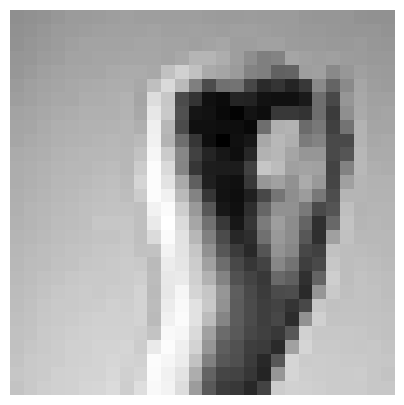

In [10]:
# Display a random sample from training data
rnd_idx = np.random.randint(len(y_train))
print(f'La imagen muestreada representa la letra: {alphabet[y_train[rnd_idx]]}')
plot_number(x_train[rnd_idx].reshape(28, 28))

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

Create mini-batches for efficient training. This allows us to process data in smaller chunks, reducing memory usage and enabling gradient updates more frequently.

## Nuestra clase Linear, ReLU y Sequential

In [ ]:
# They are imported at the top of the notebook

In [12]:
# Create the model architecture
# Input: 784 (28x28 flattened image)
# Hidden Layer 1: 256 neurons
# Hidden Layer 2: 128 neurons
# Output: 24 classes (ASL letters a-z excluding j and z)

model = Sequential_layers([
    Linear(784, 256),  # First hidden layer
    ReLU(),            # Activation
    Linear(256, 128),  # Second hidden layer
    ReLU(),            # Activation
    Linear(128, 24)    # Output layer (24 ASL letters)
])

# Training hyperparameters
mb_size = 256
learning_rate = 1e-3
epochs = 30

print("Model Architecture:")
print(f"  Input: 784 neurons")
print(f"  Hidden Layer 1: 256 neurons + ReLU")
print(f"  Hidden Layer 2: 128 neurons + ReLU")
print(f"  Output: 24 neurons (ASL letters)")
print(f"\nTraining Parameters:")
print(f"  Mini-batch size: {mb_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs: {epochs}")
print(f"\nStarting training...\n")

# Train the model
train(model, epochs, mb_size, learning_rate)

Model Architecture:
  Input: 784 neurons
  Hidden Layer 1: 256 neurons + ReLU
  Hidden Layer 2: 128 neurons + ReLU
  Output: 24 neurons (ASL letters)

Training Parameters:
  Mini-batch size: 256
  Learning rate: 0.001
  Epochs: 30

Starting training...

Epoch 1/30 - Cost: 0.0484, Validation Accuracy: 0.7434
Epoch 2/30 - Cost: 0.0198, Validation Accuracy: 0.7646
Epoch 3/30 - Cost: 0.0082, Validation Accuracy: 0.7775
Epoch 4/30 - Cost: 0.0055, Validation Accuracy: 0.7705
Epoch 5/30 - Cost: 0.0055, Validation Accuracy: 0.7772
Epoch 6/30 - Cost: 0.0035, Validation Accuracy: 0.7775
Epoch 7/30 - Cost: 0.0043, Validation Accuracy: 0.7822
Epoch 8/30 - Cost: 0.0033, Validation Accuracy: 0.7794
Epoch 9/30 - Cost: 0.0025, Validation Accuracy: 0.7833
Epoch 10/30 - Cost: 0.0020, Validation Accuracy: 0.7805
Epoch 11/30 - Cost: 0.0017, Validation Accuracy: 0.7881
Epoch 12/30 - Cost: 0.0016, Validation Accuracy: 0.7847
Epoch 13/30 - Cost: 0.0020, Validation Accuracy: 0.7869
Epoch 14/30 - Cost: 0.0017,


#### Architecture Design

For the ASL dataset, we design a fully connected neural network with the following architecture:

**Network Architecture:**
- **Input Layer:** 784 neurons (28×28 flattened images)
- **Hidden Layer 1:** 256 neurons with ReLU activation
- **Hidden Layer 2:** 128 neurons with ReLU activation  
- **Output Layer:** 24 neurons (one for each ASL letter: a-z excluding j and z)

**Rationale:**
1. **Input Size (784):** ASL images are 28×28 pixels, same as MNIST
2. **Hidden Layers:** Two hidden layers provide sufficient capacity to learn complex patterns in sign language gestures
3. **Layer Sizes:** Starting with 256 and reducing to 128 allows the network to learn hierarchical features while controlling model complexity
4. **Output Size (24):** ASL alphabet has 24 classes (26 letters minus j and z, which require motion)

**Hyperparameters:**
- **Mini-batch Size:** 256 - Balances memory usage and gradient stability
- **Learning Rate:** 1e-3 - Standard learning rate for SGD, provides stable convergence
- **Epochs:** 30 - Sufficient to achieve good performance without overfitting
- **Initialization:** Kaiming He initialization for ReLU layers

**Expected Performance:** 
- Target: ≥70% accuracy (assignment requirement)
- Expected: ~75-85% accuracy based on similar architectures

### Test your model on Random data from your test set


Testing on 15 random samples from the test set:



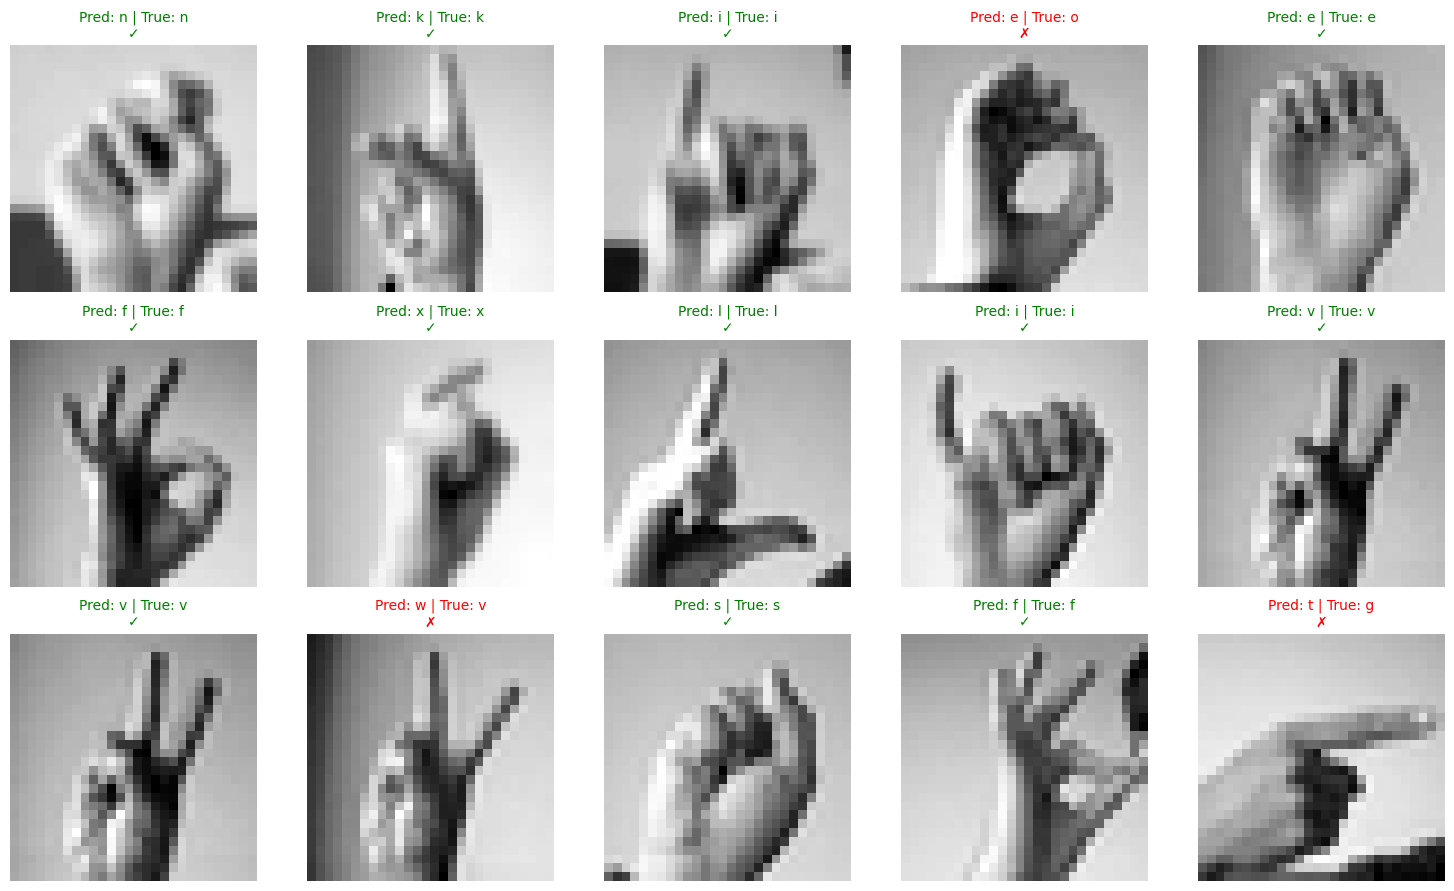

In [16]:
# Test on random samples from test set with improved printing

num_samples = 15
print(f"\nTesting on {num_samples} random samples from the test set:\n")
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for i in range(num_samples):
    idx = np.random.randint(len(y_test))
    
    # Get prediction
    pred = model.predict(x_test[idx].reshape(-1, 1))
    true_label = y_test[idx]
    is_correct = "✓" if pred == true_label else "✗"
    
    # Display result on the subplot
    axes[i].imshow(x_test[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(
        f"Pred: {alphabet[pred]} | True: {alphabet[true_label]}\n{is_correct}",
        fontsize=10,
        color='green' if is_correct == "✓" else 'red'
    )
    axes[i].axis('off')

# Remove any unused axes
for j in range(num_samples, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Evaluate Model Performance

Let's evaluate the model on the test set to see the final performance.

In [14]:
# Evaluate on test set
test_accuracy = accuracy(model, x_test, y_test, mb_size)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Check if we met the requirement
if test_accuracy >= 0.70:
    print(f"✓ Requirement met! Accuracy ≥ 70%")
else:
    print(f"✗ Requirement not met. Need ≥ 70% accuracy")

Test Accuracy: 0.7889 (78.89%)
✓ Requirement met! Accuracy ≥ 70%


In [15]:
import copy
import concurrent.futures

# Define multiple model configurations for parallel training
model_configs = [
    {
        'layers': [
            Linear(784, 256),
            ReLU(),
            Linear(256, 128),
            ReLU(),
            Linear(128, 24)
        ],
        'mb_size': 256,
        'learning_rate': 1e-3,
        'epochs': 30
    },
    {
        'layers': [
            Linear(784, 512),
            ReLU(),
            Linear(512, 128),
            ReLU(),
            Linear(128, 24)
        ],
        'mb_size': 128,
        'learning_rate': 5e-4,
        'epochs': 35
    },
    {
        'layers': [
            Linear(784, 256),
            ReLU(),
            Linear(256, 64),
            ReLU(),
            Linear(64, 24)
        ],
        'mb_size': 256,
        'learning_rate': 2e-3,
        'epochs': 25
    },
    # Add more configs as needed for experimentation
]

def train_and_eval_model(config):
    model = Sequential_layers(copy.deepcopy(config['layers']))
    mb_size = config['mb_size']
    learning_rate = config['learning_rate']
    epochs = config['epochs']
    # Each process trains its own model
    train(model, epochs, mb_size, learning_rate)
    # After training, evaluate on test set
    test_acc = accuracy(model, x_test, y_test, mb_size)
    return {
        'model': model,
        'test_accuracy': test_acc,
        'config': config
    }

print("Starting parallel training for multiple configurations...\n")

best_result = None
all_results = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for config in model_configs:
        futures.append(executor.submit(train_and_eval_model, config))
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        all_results.append(result)
        test_acc = result['test_accuracy']
        config = result['config']
        print("Configuration:")
        print(f"  Layers: {[type(layer).__name__ for layer in config['layers']]}")
        print(f"  Mini-batch size: {config['mb_size']}")
        print(f"  Learning rate: {config['learning_rate']}")
        print(f"  Epochs: {config['epochs']}")
        print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)\n")
        if not best_result or test_acc > best_result['test_accuracy']:
            best_result = result

print("Best Model Configuration Found:")
print(f"  Layers: {[type(layer).__name__ for layer in best_result['config']['layers']]}")
print(f"  Mini-batch size: {best_result['config']['mb_size']}")
print(f"  Learning rate: {best_result['config']['learning_rate']}")
print(f"  Epochs: {best_result['config']['epochs']}")
print(f"  Best Test Accuracy: {best_result['test_accuracy']:.4f} ({best_result['test_accuracy']*100:.2f}%)")

# Use the best model for further evaluation
model = best_result['model']
mb_size = best_result['config']['mb_size']

Starting parallel training for multiple configurations...

Epoch 1/25 - Cost: 0.0759, Validation Accuracy: 0.7613
Epoch 1/30 - Cost: 0.0833, Validation Accuracy: 0.7457
Epoch 1/35 - Cost: 0.1367, Validation Accuracy: 0.7460
Epoch 2/25 - Cost: 0.0091, Validation Accuracy: 0.7766
Epoch 2/30 - Cost: 0.0190, Validation Accuracy: 0.7613
Epoch 3/25 - Cost: 0.0041, Validation Accuracy: 0.7791
Epoch 3/30 - Cost: 0.0106, Validation Accuracy: 0.7688
Epoch 2/35 - Cost: 0.0325, Validation Accuracy: 0.7719
Epoch 4/25 - Cost: 0.0022, Validation Accuracy: 0.7800
Epoch 4/30 - Cost: 0.0070, Validation Accuracy: 0.7674
Epoch 5/25 - Cost: 0.0016, Validation Accuracy: 0.7842
Epoch 5/30 - Cost: 0.0039, Validation Accuracy: 0.7697
Epoch 3/35 - Cost: 0.0193, Validation Accuracy: 0.7677
Epoch 6/25 - Cost: 0.0018, Validation Accuracy: 0.7842
Epoch 6/30 - Cost: 0.0034, Validation Accuracy: 0.7694
Epoch 7/25 - Cost: 0.0010, Validation Accuracy: 0.7889
Epoch 7/30 - Cost: 0.0028, Validation Accuracy: 0.7688
Epoch 